# Assumptions

### Assumptions I am making about the nature of this ask
- I assume that there are some fixed and variable costs associated with any given program (both directly and in ease of administration), and so the client would prefer to, for example, administer a program to a single county with 100,000 members over 100 counties with 1,000 members. 
- I assume it is not my role to choose which intervention (e.g., grocery delivery, transportation assistance, mobile food pantry) to apply to improve food access, but to help the client understand where the the areas of highest need are. I understand that in some interventions are better suited for some geographic areas, but I'm ignoring this for simplicity. 

### Assumptions I am choosing to make to simplify this analysis
- I'm assuming that members of this health plan are uniformly distributed across the population of US Medicare-aged citizens 
- There are many health related outcomes in the "500 cities" data; for my primary analysis I only considered diabetes as Type II diabetes is closely tied to diet and so food access 
- I am only considering 2015 for the food access data, and I'm assuming that we can essentially consider the two datasets as having been collected at the same time (although they were a few years apart) 
- I'm assuming the proportion of diabetes in the entire population is equal to the proportion in the 65+ population


# Data import

In [425]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

# Pull five_hundred_cities (CDC - 500 Cities Project)
cursor.execute("SELECT * FROM five_hundred_cities;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
health_raw = pd.DataFrame(rows, columns=columns)

# Pull access (FDA – Food Atlas)
cursor.execute("SELECT * FROM access;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
food_raw = pd.DataFrame(rows, columns=columns)

# Pull variable_list (FDA – Food Atlas variable list)
cursor.execute("SELECT * FROM variable_list;")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
variable_list = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()

# Data Checks and EDA

## CDC 500 Cities Project ("health")

### Overview
- **Shape**: 27,210 x 64
- **Time period**: This data is from a "2019 release" but some data refers to prior years, many times 2017
- **Unit of obs**: Smallest unit of observation is "Tract" but information is available on the County, Place or State level, with the relationship that Tracts are in Counties which are in States, and Places are in States.
- **Key vars**: I will focus on the variables most relevant to this analysis, health outcomes closely associated with diet, which I assessed to be:
    - BPHIGH_CrudePrev (prev of *high blood pressure* among those 18+)
    - CHD_CrudePrev (prev of *CHD* among 18+)
    - DIABETES_CrudePrev (prev of *diabetes* among 18+)
    - HIGHCHOL_CrudePrev (prev of *high cholesterol* among 18+)
    - OBESITY_CrudePrev (prev of *obesity* among 18+)
    
### Notable Findings
- **Variable types**: 
  - StateAbbr, PlaceName, Place_TractID are _object_
  - Population2010 is _int64_
  - outcomes are _float64_
- **Missingness**: No missingness in vars of interest
- **Duplication**: No duplication in Place_TractID
- **Distributions and Outliers**: All prevlance values do fall in [0, 100] and IQR is pretty tight within each outcome measure, but there is great between-outcome variation with, for example, HBP being more prevalent than CHD. Max and Mins are quite far from IQR in most cases but not enough for me to suspect data issues. 
- **Other**
  -  PlaceFIPS and TractFIPS came in as integers so early-alphabet countires are missing leading 0s - so I only kept Place_TractID which I'll use to extract State FIPS and County FIPS 
  - Place_TractID for Honolulu HI (234 obs) only has the "Tract" part, and no hyphen 


In [426]:
## Size
health_raw.shape

## Keep key variables
id_info = ['StateAbbr', 'PlaceName', 'Place_TractID', 'Population2010']
key_outcomes_health = ['BPHIGH_CrudePrev', 'CHD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'OBESITY_CrudePrev']
health = health_raw[id_info + key_outcomes_health].copy()

## Variable types
health.dtypes

## Missingness
health.isna().sum()

## Duplication
health.duplicated('Place_TractID').sum()

## Place_TractID has hyphen and is correct length?
no_hyphen = health[~health['Place_TractID'].str.contains('-')]
not_length_19 = health[health['Place_TractID'].str.len() != 19]
(no_hyphen == not_length_19).all()
not_length_19.value_counts(id_info)

## Distributions and Outliers
health[key_outcomes_health].describe()

,BPHIGH_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev
count,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000
mean,30.653208,5.602977,10.811062,31.364296,30.472922
std,8.260472,2.118858,4.269441,4.887047,8.180685
min,5.300000,0.300000,0.800000,6.900000,9.600000
25%,25.300000,4.200000,7.900000,28.800000,24.500000
50%,29.500000,5.300000,10.000000,31.700000,29.500000
75%,34.900000,6.700000,12.900000,34.400000,35.600000
max,70.300000,35.800000,39.500000,55.400000,58.600000


## FDA Food Atlas ("food")
### Overview
- **Shape**: 3,143 x 43
- **Time period**: Data largely collected from 2010 and 2015, and variables are often included that calculate prevalence in these years and the percent change between them
- **Unit of obs**: Smallest unit of observation is "County." Some data is not available on the County-level, but only the state or regional level - these variables are indicated with asterisks
- **Key vars:** I'll focus on variables most relevant to this analysis, which I assessed to be those directly related to "food access" and not other variables (pertaining to stores, assistance, etc.) which are available for download and described in variable_list. To simplify I'll only consider the 2015 variables:
    - [PCT_]LACCESS_POP15 (count/percent, low access to store, 2015)
    - [PCT_]LACCESS_LOWI15 (count/percent, low income + low access to store, 2015)
    - [PCT_]LACCESS_HHNV15 (count/percent, no car + low access to store, 2015)
    - [PCT_]LACCESS_SNAP15 (count/percent, snap household + low access to store, 2015)
    - [PCT_]LACCESS_SENIORS15 (count/percent, **senior** + low access to store, 2015)
    - [PCT_]LACCESS_[RACE]15 (count/percent, given race + low access to store, 2015)
- **Other notes**
  - Population counts not included but can be back-calculated from counts and proportions
  - Empty/missing denoted by -9999


### Takeaways
- **Variable types**: 
  - StateAbbr, FIPS is _int64_
  - State and County are _object_
  - outcomes are _float64_
- **Missingness**:
  - None missing for FIPS, State, or County
  - There are only 20 total rows with at least one missing outcome value (if one variable is missing for a county, many or all other outcome vars are missing). Spread across geography (with most in VA).
  - There are no -9999 values
  - I'll restrict to complete cases and ignore these counties for simplicity   
- **Duplication**: No duplication in FIPS
- **Distributions and Outliers**: 
  - **counts**
      - Zero counts
          - There are 9 counties with no low access population
          - Looking up a couple of the 9, like Greene VA, this seems reasonable for these counties and not a data error.
      - Non-integer counts
          - Counts aren't integers, suggesting they are calculated using total population and proportion variables. More on this below.
      - Low counts
        - Counts are lower than I would expect for certain race variables. For example, the 75% ptile count of hispanic residents in a county is only 874
  - **pcts**
      - All values sit in [0, 100] as expected and the median overall low access pct is 19% 
      - ~100% low access
        - There are 83 counties with low access > 99%. They tend to be very small (the largest, in Alaska, has a population of ~5,500) and rural (most are in rural Texas and Nebraska)

- **Other**
  - Corresponcence between pct and count variables
      - It appears that counts are calculated from pct and population - meaning count/pct should yield the same county-level population count no matter which sets of count/pct variables are used to calculate it. This is the case for the few var sets I checked.
      - Calculated populations match (roughly) what I find online when I check county pops.
      - This won't work in the case of 0% low access though, so I'll remove them from the analysis instead of looking up populations (there are only 9, none overlap with health data county set, and they weren't candidates for a program like this anyway..)
    
  - FIPS is an interger and so missing a leading 0 for those early-alphabet countries, I'll add it back and make it a string to extract State and County FIPS when merging 


In [427]:
## Size
food_raw.shape

## Keep key variables
id_info = ['FIPS', 'State', 'County']
key_var_snippets = ['POP', 'LOWI', 'HHNV', 'SNAP', 'SENIORS', 'WHITE', 'BLACK', 'HISP', 'NHASIAN', 'NHNA', 'NHPI', 'MULTIR']
count_outcomes = ['LACCESS_' + snippet + '15' for snippet in key_var_snippets]
pct_outcomes = ['PCT_' + count_outcome for count_outcome in count_outcomes]
key_outcomes_food = count_outcomes + pct_outcomes
food = food_raw[id_info + key_outcomes_food].copy()

## Variable types
food.dtypes

## Missingness
food.isna().sum()
food[key_outcomes_food].eq(-9999).sum()
rows_with_missing_vals = food[food.isna().any(axis=1)]

## Duplication
food.duplicated('FIPS').sum()

## Correspondence between counts and pct
food_restricted = food[['LACCESS_POP15', 'PCT_LACCESS_POP15', 'LACCESS_LOWI15', 'PCT_LACCESS_LOWI15']].copy()
food_restricted['populationPOP'] = food_restricted['LACCESS_POP15']/(food_restricted['PCT_LACCESS_POP15']*.01)
food_restricted['populationLOWI'] = food_restricted['LACCESS_LOWI15']/(food_restricted['PCT_LACCESS_LOWI15']*.01)
food_restricted.head(50)

## Distributions and Outliers
# Counts
food[count_outcomes].describe()
food.sort_values('LACCESS_POP15').tail(40)

# Pcts
low_access = food.loc[food['PCT_LACCESS_POP15'] > 99, id_info + ['LACCESS_POP15', 'PCT_LACCESS_POP15']]
low_access.sort_values('LACCESS_POP15')
low_access.value_counts('State')
food[pct_outcomes].describe()

,PCT_LACCESS_POP15,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_SENIORS15,PCT_LACCESS_WHITE15,PCT_LACCESS_BLACK15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15
count,3124.000000,3123.000000,3140.000000,3123.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000
mean,23.084470,8.651256,3.289225,2.917896,3.791364,18.976973,1.879652,2.021269,0.249350,0.804746,0.019207,1.154542
std,19.602745,8.368703,3.213497,3.160642,3.967098,17.529867,4.139239,5.030497,0.693856,4.835109,0.134887,1.864479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.927326,3.625438,1.683158,1.132022,1.634053,8.518008,0.056762,0.197446,0.027088,0.026997,0.000000,0.221558
50%,19.200682,6.508531,2.672985,2.128783,2.769164,15.185443,0.257221,0.579669,0.085588,0.072033,0.003242,0.572597
75%,28.862231,10.679796,4.036167,3.668171,4.403062,23.658599,1.682592,1.673132,0.249311,0.186646,0.013054,1.318699
max,100.000001,71.844209,60.602394,37.254488,29.146426,99.163179,50.136324,79.323968,25.087551,83.844210,4.469546,27.120652


## Relationship between "health" and "food" data

### Pre-merge observations and consderations

**Observations**
- Health data contains 326 counties
  - All 50 states + DC, 5 per state on median, at most 35 counties per state (in Texas), and only 1 county per state in 11 states, mostly the smallest ones incl. VT, NH, ND
- Food data contains 3,143 counties (3,114 after dropping those with missing data or 0% low access)
  - There are 3,143 counties in the US (google), so all are represented

**Considerations**
- As County is the largest shared FIPS level, I'll merge these two at this level. Another idea would be to keep the _health_ data disaggregated at the Tract level and merge on _food_ at the county level.
- As the health data is disaggregated by Tract FIPS, in order to get a single row for each County FIPS, I will combine information on the county level by computing a weighted average (by population, for the available Tracts within each county) of each variable of interest. 
- My understanding it that it is **not** the case that for a given county included in this dataset, all Tracts within this county are also included. This is clear from just looking at aggregated populations by County and number of tracts per county, which are often much lower than expected (based on google). This damages the reliability of weighted average measures on a county level, but I still think this is the best option. 
  
### Post-merge Takeaways
- While counties in health are indeed a subset of counties in food, 325/326 health counties merged onto food because I dropped Alexandria VA (51510) since it has missing food outcome data


In [429]:
### Clean "health" data (five_hundred_cities) ###
# Create StateFIPS and CountyFIPS
health.loc[~health['Place_TractID'].str.contains('-'), 'Place_TractID'] = "-" + health['Place_TractID'] # Handle Honolulu
health['StateFIPS'] = health['Place_TractID'].str.split('-').str[1].str[0:2]
health['CountyFIPS'] = health['Place_TractID'].str.split('-').str[1].str[2:5]
health['State_CountyFIPS'] = health['StateFIPS'] + health['CountyFIPS']

# Aggregate on CountyFIPS level
wtd_avg = lambda x: np.average(x, weights=health.loc[x.index, 'Population2010'])
health_agg = health.groupby(['StateAbbr', 'State_CountyFIPS', 'StateFIPS', 'CountyFIPS']).agg(
    TractsPerCounty=('Place_TractID', 'count'),
    **{outcome : (outcome, wtd_avg) for outcome in key_outcomes_health}
).sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

# Count counties
health_agg.value_counts('StateAbbr')
health_agg.value_counts('StateAbbr').describe()

# Check tracts per county
tracts_and_pop = health.groupby(['StateAbbr', 'StateFIPS', 'CountyFIPS']).agg(
    TractsPerCounty=('Place_TractID', 'count'),
    Pop=('Population2010', 'sum')
).sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

In [430]:
#### Clean "food" data (access) ###
# Create StateFIPS and CountyFIPS
food['FIPS'] = food['FIPS'].astype(str)
food['FIPS'].str.len().value_counts() # making sure FIPS is only 4 or 5 chars at this point (it is)
food['FIPS'] = food['FIPS'].apply(lambda x: '0' + x if len(str(x)) == 4 else x)
food['StateFIPS'] = food['FIPS'].str[0:2]
food['CountyFIPS'] = food['FIPS'].str[2:5]
food['State_CountyFIPS'] = food['StateFIPS'] + food['CountyFIPS']
food.sort_values(['StateFIPS', 'CountyFIPS']).reset_index()

# Create population
food['population'] = food['LACCESS_POP15']/(food['PCT_LACCESS_POP15']*.01)

# Remove counties with missing outcome data (20) or 0% food access (9)
food = food.dropna()

# Count counties
food.value_counts('State')
food.value_counts('State').describe()

count     51.000000
mean      61.058824
std       46.114385
min        1.000000
25%       23.500000
50%       62.000000
75%       87.500000
max      252.000000
dtype: float64

In [320]:
### Merge ###
health_food = pd.merge(health_agg, food, on = ['State_CountyFIPS', 'StateFIPS', 'CountyFIPS'], how = 'inner')
health_food = health_food.drop(['State', 'FIPS'], axis=1)

# Checking merge results
set(health['StateFIPS'] + health['CountyFIPS']) - set(health_food['StateFIPS'] + health_food['CountyFIPS'])
display(health_food)

,StateAbbr,State_CountyFIPS,StateFIPS,CountyFIPS,TractsPerCounty,BPHIGH_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev,...,PCT_LACCESS_WHITE15,PCT_LACCESS_BLACK15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15,population,pct_sr_of_laccess,pct_lowi_of_laccess
0,AL,01073,01,073,105,42.264688,6.812536,14.731505,33.881172,38.806230,...,14.413185,15.492052,1.077910,0.274585,0.072433,0.012159,0.968462,658466.0,0.126281,0.392906
1,AL,01083,01,083,2,31.002170,3.502564,7.797041,27.640039,31.716174,...,8.232448,2.426806,0.515501,0.036740,0.073212,0.002703,0.510039,82782.0,0.152181,0.311857
2,AL,01089,01,089,56,37.584589,6.747876,11.909898,33.373674,35.672965,...,17.275220,6.813563,1.489089,0.804888,0.182551,0.023573,1.346179,334811.0,0.110993,0.282362
3,AL,01097,01,097,75,42.438867,7.650769,14.330603,35.072716,37.866306,...,15.637494,8.321303,0.493845,0.480093,0.136825,0.013695,0.536656,412992.0,0.131890,0.408577
4,AL,01101,01,101,60,41.363430,6.877821,14.289144,34.355537,38.661543,...,8.355226,18.897440,1.321648,0.311002,0.081292,0.026284,1.182867,229363.0,0.103407,0.505028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,WI,55087,55,087,20,27.264233,5.200865,8.005271,32.874209,32.273715,...,10.863714,0.077669,0.418985,0.279124,0.063212,0.003819,0.349441,176695.0,0.104563,0.210001
321,WI,55101,55,101,22,31.613441,5.830619,9.985795,32.965770,40.092135,...,24.384183,3.311874,3.468957,0.286894,0.132587,0.007875,2.391545,195408.0,0.120534,0.272829
322,WI,55133,55,133,20,26.273569,4.571882,7.097231,30.818319,31.228096,...,33.511763,0.493064,1.429542,0.865391,0.105376,0.011869,0.776626,389891.0,0.130226,0.141606
323,WI,55139,55,139,1,28.700000,6.500000,8.100000,31.500000,29.700000,...,19.100384,0.406957,0.604552,0.521789,0.120768,0.008095,0.486697,166994.0,0.128732,0.241682


# Analysis and Plots

## 1. Mapping Important Variables


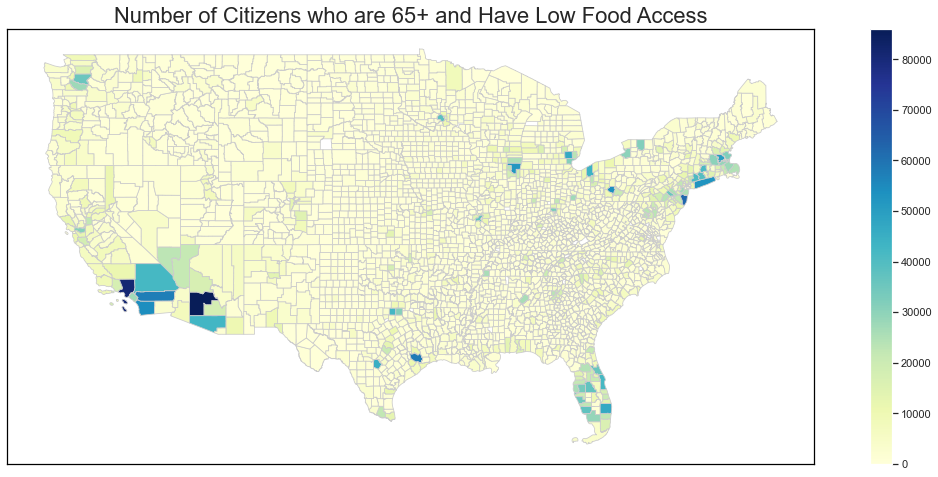

In [230]:
import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

# Read the counties shapefile
counties = gpd.read_file('tl_rd22_us_county.shp')

# Rename GEOID for merging
counties.rename(columns={'GEOID':'State_CountyFIPS'}, inplace=True)

# Restrict to include only continental US (only for plotting = HI and AK are included in rest of analysis)
continental_us_bbox = [-125, 24, -66, 49]  # [minx, miny, maxx, maxy]
counties = counties.cx[continental_us_bbox[0]:continental_us_bbox[2],
                      continental_us_bbox[1]:continental_us_bbox[3]]

# Merge food data onto counties via State_CountyFIPS
counties_food = counties.merge(food, on='State_CountyFIPS', how='left')

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
counties_food.plot(column='LACCESS_SENIORS15', cmap='YlGnBu', linewidth=0.8, 
                   ax=ax, edgecolor='0.8', legend=True)

# Options
ax.set_facecolor('white')
plt.title('Number of Citizens who are 65+ and Have Low Food Access', fontsize=22)
plt.xticks([])
plt.yticks([])

# Draw border
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Display 
plt.show()


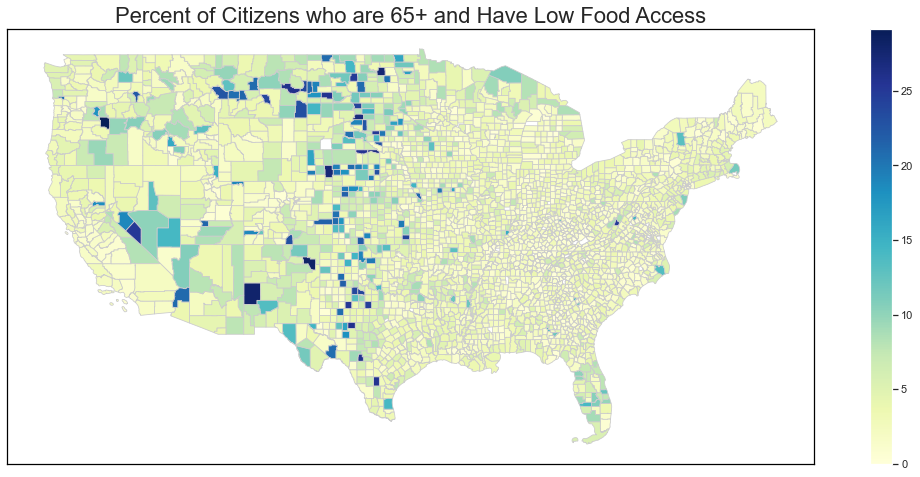

In [321]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
counties_food.plot(column='PCT_LACCESS_SENIORS15', cmap='YlGnBu', linewidth=0.8, 
                   ax=ax, edgecolor='0.8', legend=True)

# Options
ax.set_facecolor('white')
plt.title('Percent of Citizens who are 65+ and Have Low Food Access', fontsize=22)
plt.xticks([])
plt.yticks([])

for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Display 
plt.show()

## 2. Distributions of Important Variables

### Food access


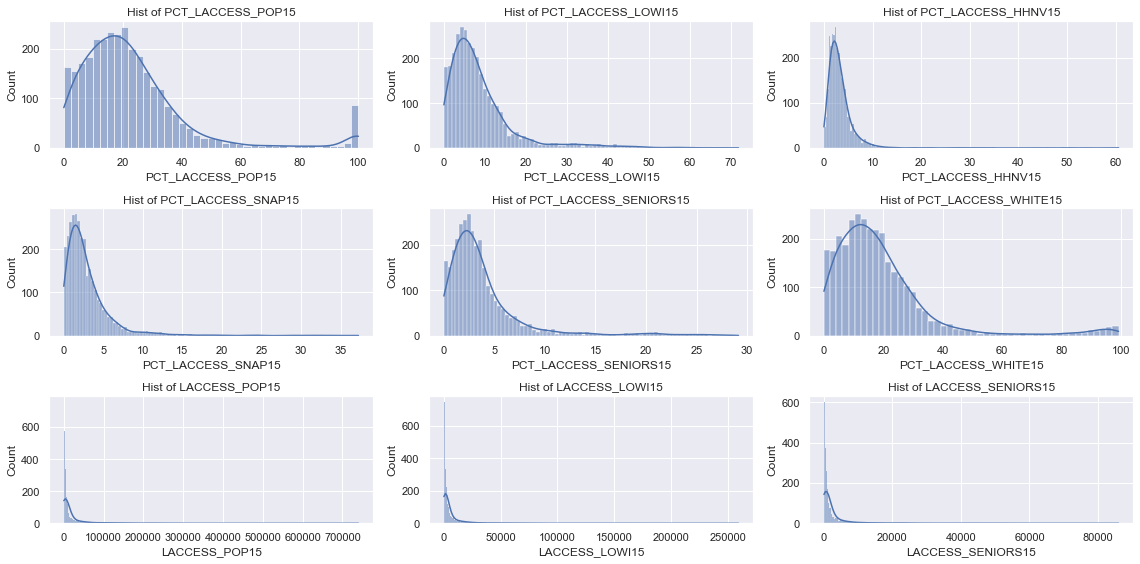

In [358]:
# Food vars
food_vars = [
    'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 
    'PCT_LACCESS_SNAP15', 'PCT_LACCESS_SENIORS15', 'PCT_LACCESS_WHITE15',
    'LACCESS_POP15', 'LACCESS_LOWI15', 'LACCESS_SENIORS15'
]

# Rows and cols
n_rows = 3  
n_cols = 3

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))

# Flatten axes array
axes = axes.flatten()

# Create plots
for i, column in enumerate(food_vars):
    ax = axes[i]  # Select the current subplot
    
    # Plot
    sns.histplot(data=food, x=column, kde=True, ax=ax)
    
    # Title
    ax.set_title(f'Hist of {column}')
    

# Adjust spacing
fig.tight_layout()

# Display
plt.show()

### Health

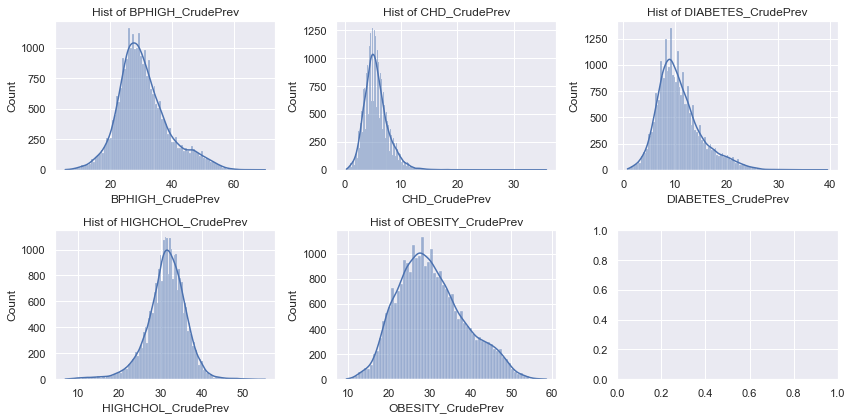

In [327]:
# Health vars
health_vars = ['BPHIGH_CrudePrev', 'CHD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev', 'OBESITY_CrudePrev']

# Rows and cols
n_rows = 2  
n_cols = (len(columns) + 1) // 2 

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

# Flatten axes array
axes = axes.flatten()

# Create plots
for i, column in enumerate(health_vars):
    ax = axes[i]  # Select the current subplot
    
    # Plot
    sns.histplot(data=health, x=column, kde=True, ax=ax)
    
    # Title
    ax.set_title(f'Hist of {column}')
    

# Adjust spacing
fig.tight_layout()

# Display
plt.show()

## 3. Creating an "Impact Score" in the food access data 

### Create and normalize variables

In [276]:
# For Z score
from scipy.stats import zscore

# Create variables
food['pct_sr_of_laccess'] = food['LACCESS_SENIORS15']/food['LACCESS_POP15']
food['pct_lowi_of_laccess'] = food['LACCESS_LOWI15']/food['LACCESS_POP15']
food_plot = food[['State_CountyFIPS', 'FIPS', 'State', 'County', 'population', 'LACCESS_SENIORS15', 
                  'pct_sr_of_laccess', 'PCT_LACCESS_HHNV15', 'pct_lowi_of_laccess', 'PCT_LACCESS_SNAP15']].copy()

# Set variables to normalize via. Z score
vars_to_normalize = ['pct_sr_of_laccess', 'PCT_LACCESS_HHNV15', 'pct_lowi_of_laccess', 'PCT_LACCESS_SNAP15']

# Normalize
for var in vars_to_normalize:
    var_name = f'{var}_z'
    food_plot[var_name] = zscore(food_plot[var])
    
# Sum across normalized vars to create impact score
food_plot['impact_score'] = food_plot.loc[:, 'pct_sr_of_laccess_z':'PCT_LACCESS_SNAP15_z'].sum(axis=1)
food_plot

,State_CountyFIPS,FIPS,State,County,population,LACCESS_SENIORS15,pct_sr_of_laccess,PCT_LACCESS_HHNV15,pct_lowi_of_laccess,PCT_LACCESS_SNAP15,pct_sr_of_laccess_z,PCT_LACCESS_HHNV15_z,pct_lowi_of_laccess_z,PCT_LACCESS_SNAP15_z,impact_score
0,01001,01001,AL,Autauga,54571.0,2180.809285,0.124641,3.351332,0.373995,4.608749,-0.708887,0.022592,-0.020438,0.532277,-0.174456
1,01003,01003,AL,Baldwin,182265.0,5580.662790,0.182606,1.905114,0.323509,1.298900,0.383927,-0.427984,-0.442454,-0.514879,-1.001390
2,01005,01005,AL,Barbour,27457.0,824.175262,0.135789,4.329378,0.485836,4.303147,-0.498714,0.327307,0.914434,0.435592,1.178619
3,01007,01007,AL,Bibb,22915.0,137.688231,0.142038,2.821427,0.614995,0.676710,-0.380911,-0.142502,1.994072,-0.711725,0.758934
4,01009,01009,AL,Blount,57322.0,505.914282,0.135837,3.336414,0.443279,0.812727,-0.497816,0.017944,0.558702,-0.668693,-0.589862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,56037,WY,Sweetwater,43806.0,1951.212126,0.103049,2.182752,0.250910,2.141828,-1.115962,-0.341485,-1.049307,-0.248197,-2.754952
3139,56039,56039,WY,Teton,21294.0,657.160241,0.105782,0.540222,0.253972,0.670815,-1.064439,-0.853223,-1.023711,-0.713590,-3.654964
3140,56041,56041,WY,Uinta,21118.0,437.130401,0.093284,2.759922,0.438364,2.072485,-1.300069,-0.161665,0.517617,-0.270136,-1.214252
3141,56043,56043,WY,Washakie,8533.0,219.490015,0.235653,1.203633,0.331787,1.053980,1.384036,-0.646535,-0.373254,-0.592366,-0.228119


### Plot associations between impact score compenent and diabetes prevalence
- Positive assocations between impact score components and diabetes prevalence
- Going forward, I'd calculate correlations and consider a broader set of candidate impact score components and use correlations analysis to inform which are included, in conjunction with published research/subject matter knowledge 

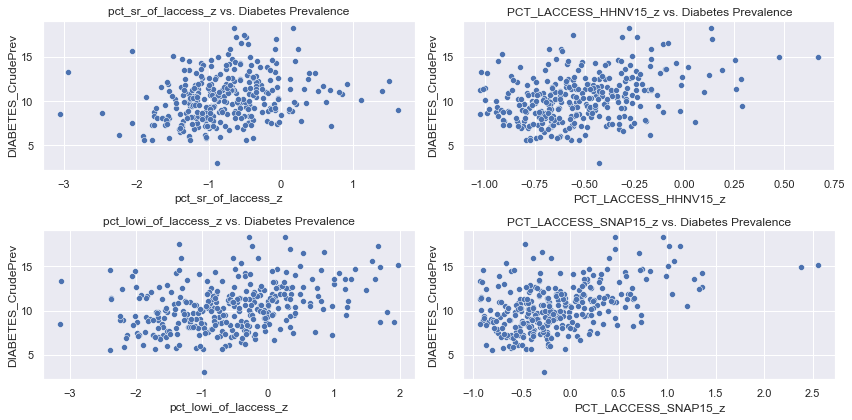

In [345]:
# Health vars
normalized_access_vars = ['pct_sr_of_laccess_z', 'PCT_LACCESS_HHNV15_z', 'pct_lowi_of_laccess_z', 'PCT_LACCESS_SNAP15_z']

# Merge impact score onto merged dataset (health_food)
health_food_impact = pd.merge(health_food, food_plot, on='State_CountyFIPS', how='left')

# Rows and cols
n_rows = 2  
n_cols = 2

# Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

# Flatten axes array
axes = axes.flatten()

# Create plots
for i, column in enumerate(normalized_access_vars):
    ax = axes[i]  # Select the current subplot
    
    # Plot
    sns.scatterplot(data=health_food_impact, x=column, y='DIABETES_CrudePrev', ax=ax)
    
    # Title
    ax.set_title(f'{column} vs. Diabetes Prevalence')
    

# Adjust spacing
fig.tight_layout()

# Display
plt.show()

### Regress impact score components on diabetes prevalence
- Results showing strong association with SNAP and percent senior among all low access individuals, and suprisingly, no significant effect of no-vehicle-household percentage. 
- Could use this in the future to assign weights and inform construction of impact score
- Since this isn't a sufficient approach yet, I'll move forward with just assigning each variable a weight of 1

In [346]:
# Fit Regression
# NOTE: With more time I'd fit a Beta Regression as the outcome is a percentage in [0-1], 
# sticking with linear reg bc of time constraints

import statsmodels.api as sm

# Create design X and y
X = sm.add_constant(health_food_reg[normalized_access_vars])
y = health_food_reg['DIABETES_CrudePrev']

# Fit model
model = sm.OLS(y, X)
result = model.fit()

# Results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     DIABETES_CrudePrev   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     30.44
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           1.78e-21
Time:                        11:52:58   Log-Likelihood:                -719.31
No. Observations:                 325   AIC:                             1449.
Df Residuals:                     320   BIC:                             1468.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.43

### Plot
- Plotting number of seniors with low access vs. impact score, by county
- Negative correlation suggesting highest impact to be made in small communities


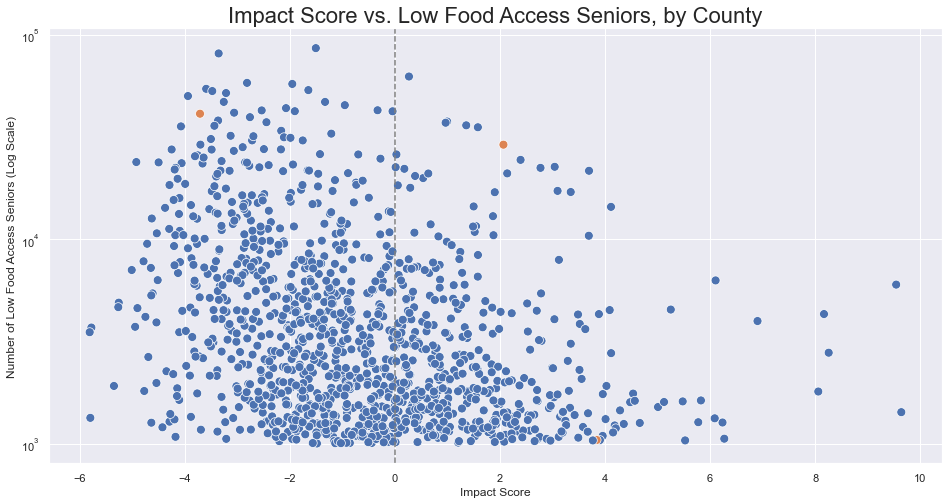

In [322]:
# Restrict to include those with > 1000 SSs with low access
food_plot_r = food_plot[food_plot.LACCESS_SENIORS15 > 1000].copy()
food_plot_r['special_pt'] = "No"
food_plot_r.loc[food_plot_r['FIPS'].isin(["09001", "35003", "12021"]), 'special_pt'] = "Yes"

# Plot
plt.figure(figsize=(16, 8)) 
sns.scatterplot(data=food_plot_r, x='impact_score', y='LACCESS_SENIORS15', hue='special_pt', s=80, legend=False)
plt.axvline(x=0, color='gray', linestyle='--')

# Options
plt.yscale('log')
plt.title('Impact Score vs. Low Food Access Seniors, by County', fontsize=22)
plt.xlabel('Impact Score')
plt.ylabel('Number of Low Food Access Seniors (Log Scale)')

# Show
plt.show()


### Map

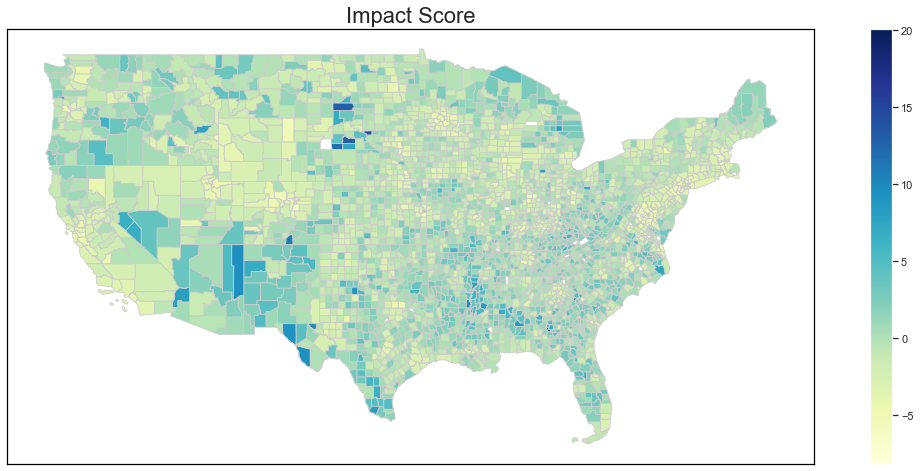

In [298]:
# Merge food data onto counties via State_CountyFIPS
counties_food_plot = counties.merge(food_plot, on='State_CountyFIPS', how='left')

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
counties_food_plot.plot(column='impact_score', cmap='YlGnBu', linewidth=0.8, 
                   ax=ax, edgecolor='0.8', legend=True)

# Options
ax.set_facecolor('white')
plt.title('Impact Score', fontsize=22)
plt.xticks([])
plt.yticks([])

for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Display 
plt.show()

## Population at risk by state

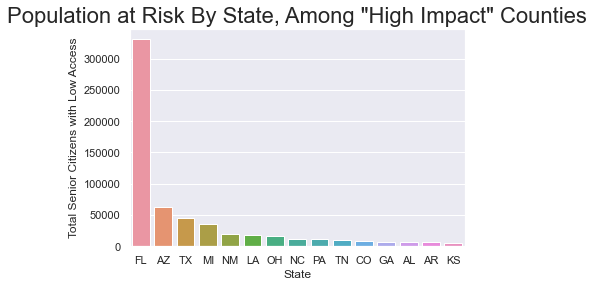

In [417]:
food_plot_r_agg = food_plot_r.copy()
food_plot_r_agg = food_plot_r_agg[(food_plot_r_agg.LACCESS_SENIORS15 > 5000) & (food_plot_r_agg.impact_score > 0.75)]
food_plot_r_agg = food_plot_r_agg.groupby('State').agg(
    PopAtRisk=('LACCESS_SENIORS15', 'sum'),
    Count=('LACCESS_SENIORS15', 'count')
).sort_values('PopAtRisk', ascending=False).reset_index()

# Size
#plt.figure(figsize=(12, 8)) 

# Plot
sns.barplot(data=food_plot_r_agg, x='State', y='PopAtRisk')

# Options
plt.xlabel('State')
plt.ylabel('Total Senior Citizens with Low Access')
plt.title('Population at Risk By State, Among "High Impact" Counties', fontsize=22)

# Show
plt.show()

## Demographic breakdown
- I am estimating the race dist. among seniors with low access from the total populations race distribution. These are estimated counts, but I figured they are better than nothing.
- I can't do a full race breakdown because race categories seem to be overlapping
- I'm assuming that all white people do not identify as another race as well
- For income dist., I'm likewise assuming low-income proportion is the same in seniors with low access and total population with low access

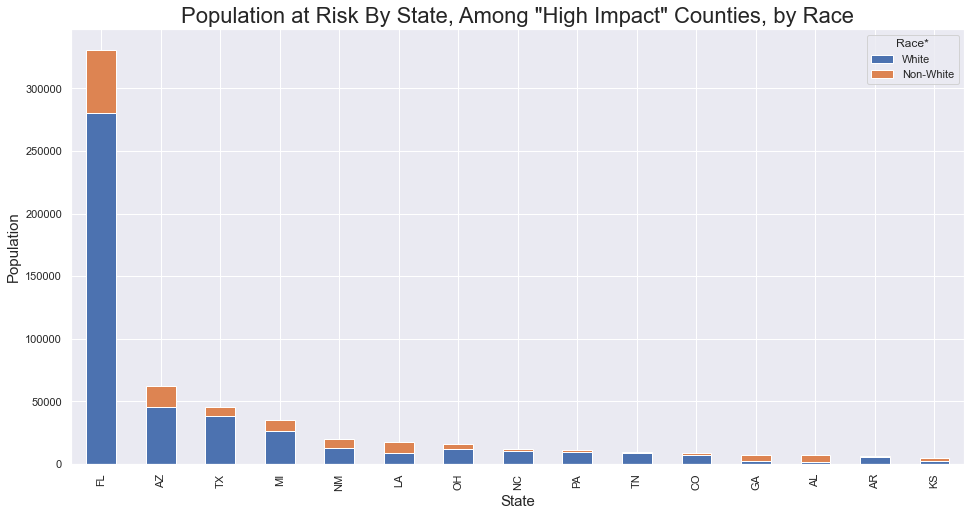

In [414]:
# New dataset
food_race = food.copy()

# Aggregate
food_race_agg = pd.merge(food_demo, food_plot[['State_CountyFIPS', 'impact_score']], on='State_CountyFIPS', how='left')
food_race_agg = food_race_agg[(food_race_agg.LACCESS_SENIORS15 > 5000) & (food_race_agg.impact_score > 0.75)]
food_race_agg = food_race_agg.groupby('State').agg(
    PopAtRiskTotal=('LACCESS_POP15', 'sum'),
    PopAtRiskSr=('LACCESS_SENIORS15', 'sum'),
    PopAtRiskWhite=('LACCESS_WHITE15', 'sum'),
    Count=('LACCESS_SENIORS15', 'count')
).sort_values('PopAtRiskSr', ascending=False).reset_index()

# Round
food_race_agg.loc[:, 'PopAtRiskTotal':'PopAtRiskWhite'] = food_race_agg.loc[:,'PopAtRiskTotal':'PopAtRiskWhite'].round().astype(int)
food_race_agg['total_not_white'] = food_inc_agg['PopAtRiskTotal'] - food_race_agg['PopAtRiskWhite']  
food_race_agg['total_white_sr'] = (food_race_agg['PopAtRiskWhite'] / food_race_agg['PopAtRiskTotal'] * food_race_agg['PopAtRiskSr']).round().astype(int)
food_race_agg['total_not_white_sr'] = (food_race_agg['PopAtRiskSr'] - food_race_agg['total_white_sr']).round().astype(int)

# Plot
food_race_agg.set_index('State')[['total_white_sr', 'total_not_white_sr']].plot(kind='bar', stacked=True)

# Options
plt.gcf().set_size_inches(16, 8)
plt.xlabel('State', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.title('Population at Risk By State, Among "High Impact" Counties, by Race', fontsize=22)
plt.legend(title='Race*', labels=['White', 'Non-White'])
plt.xticks(rotation=90)

# Display
plt.show()

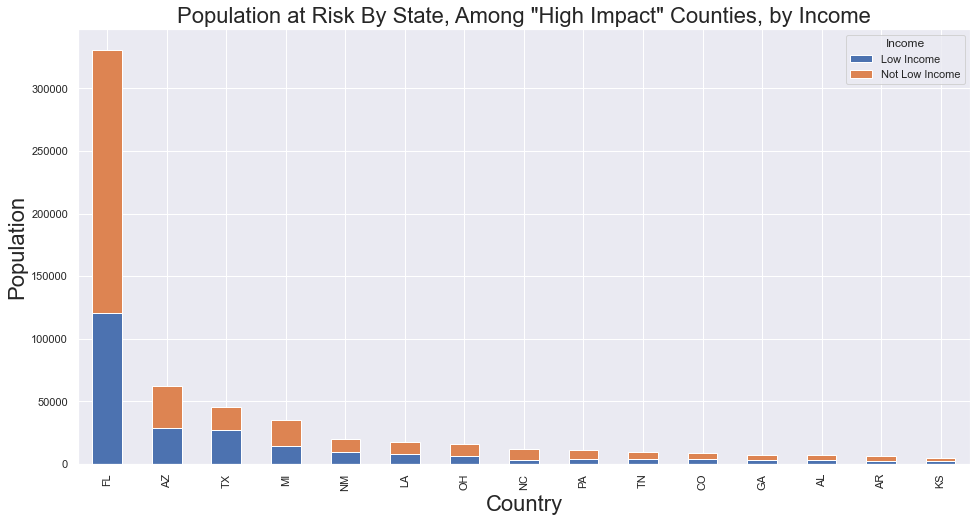

In [432]:
# New dataset
food_inc = food.copy()

# Aggregate
food_inc_agg = pd.merge(food_demo, food_plot[['State_CountyFIPS', 'impact_score']], on='State_CountyFIPS', how='left')
food_inc_agg = food_inc_agg[(food_inc_agg.LACCESS_SENIORS15 > 5000) & (food_inc_agg.impact_score > 0.75)]
food_inc_agg = food_inc_agg.groupby('State').agg(
    PopAtRiskTotal=('LACCESS_POP15', 'sum'),
    PopAtRiskSr=('LACCESS_SENIORS15', 'sum'),
    PopAtRiskLowi=('LACCESS_LOWI15', 'sum'),
    Count=('LACCESS_SENIORS15', 'count')
).sort_values('PopAtRiskSr', ascending=False).reset_index()

# Round
food_inc_agg.loc[:, 'PopAtRiskTotal':'PopAtRiskLowi'] = food_inc_agg.loc[:,'PopAtRiskTotal':'PopAtRiskLowi'].round().astype(int)
food_inc_agg['total_hinc'] = food_inc_agg['PopAtRiskTotal'] - food_inc_agg['PopAtRiskLowi']  
food_inc_agg['total_linc_sr'] = (food_inc_agg['PopAtRiskLowi'] / food_inc_agg['PopAtRiskTotal'] * food_inc_agg['PopAtRiskSr']).round().astype(int)
food_inc_agg['total_nlinc_sr'] = (food_inc_agg['PopAtRiskSr'] - food_inc_agg['total_linc_sr']).round().astype(int)


# Plot
food_inc_agg.set_index('State')[['total_linc_sr', 'total_nlinc_sr']].plot(kind='bar', stacked=True)

# Options
plt.gcf().set_size_inches(16, 8)
plt.xlabel('Country', fontsize=22)
plt.ylabel('Population', fontsize=22)
plt.title('Population at Risk By State, Among "High Impact" Counties, by Income', fontsize=22)
plt.legend(title='Income', labels=['Low Income', 'Not Low Income'])
plt.xticks(rotation=90)

# Display
plt.show()

## 4. Regressing [percent SS and low access] on [diabetes prevalence]

- I'm running a regression on the merged dataset to assess the association between percent SS and low access on diabetes prevalence
- I'm crucially including main effect and interaction of impact_score because I believe the effect of the intervention is modified by certain characteristics of the county which are wrapped up in impact score - each county *should* have its own slope corresponding to an incremenal increase (or more topically, decrease) in the percentage of senior citizens that have low food access.
- If I had more time I would explore better modeling this data generating process using Beta Regression, consider non-linearities, or include additional covariates with demographic and socioeconomic factors. 
- Also worth using count instead of pct of low access seniors as key covariate. I think this simplifies interpretation a bit but I'd prob have to transform it to adhere to regression assumptions which might complicate interpretation 
- b1 and b3 are not significant at the 0.05 level but I will use these point estimates regardless for the sake of explanation (and because a better model might have yielded significant effects)
- Adj-R squared is also low here, suggesting poor fit which suggests it's dangerous to use these coefficients for prediction (as I will do in the next step..) 

In [434]:
# Merge impact score onto merged dataset (health_food)
health_food_reg = pd.merge(health_food, food_plot[['State_CountyFIPS', 'impact_score']], on='State_CountyFIPS', how='left')

# Fit Regression
# NOTE: With more time I'd fit a Beta Regression as the outcome is a percentage in [0-1], 
# sticking with linear reg bc of time constraints

import statsmodels.api as sm

# Create interaction term
health_food_reg['interaction'] = health_food_reg['PCT_LACCESS_SENIORS15'] * health_food_reg['impact_score']

# Create design X and y
X = sm.add_constant(health_food_reg[['PCT_LACCESS_SENIORS15', 'impact_score', 'interaction']])
y = health_food_reg['DIABETES_CrudePrev']

# Fit model
model = sm.OLS(y, X)
result = model.fit()

# Results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     DIABETES_CrudePrev   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     35.45
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           8.12e-20
Time:                        17:13:38   Log-Likelihood:                -725.20
No. Observations:                 325   AIC:                             1458.
Df Residuals:                     321   BIC:                             1474.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.61

## 5. Create Ranked List of Counties by Impact
- Note that I only ran the regression on the subset of counties for which I had health and food access data (as I needed the diabetes-related outcome by county for the regression), but I am now going to apply the regression coefficients to the comprehensive set of counties in the food access data. 
- The goal is to estimate the incremental effect of a unit decrease in [percent SS and low access] on [diabetes prevalence] for each county, considering its imapct_score, and rank them.
- This incremental effect is a linear function of impact_score, in particular, b1+b3*impact_score, and so the ranked list will correspond to the ranked list of impact scores, but will contain a more meaningful interpretation in terms of diabetes prevalence. 

In [435]:
# Reg params
b1 = result.params['PCT_LACCESS_SENIORS15']
b3 = result.params['interaction']

# Create ranked list
food_ranked_counties = food_plot[['FIPS', 'State', 'County', 'population', 'LACCESS_SENIORS15', 'impact_score']].copy()
food_ranked_counties['county_impact'] = -1*(b1 + b3*food_ranked_counties['impact_score'])

### Highest impact score among those at-risk populations > 10,000

In [436]:
food_ranked_counties.loc[food_ranked_counties.LACCESS_SENIORS15 > 10000].sort_values('county_impact').head(15).reset_index()

,index,FIPS,State,County,population,LACCESS_SENIORS15,impact_score,county_impact
0,328,12017,FL,Citrus,141236.0,14388.647269,4.113269,-0.324059
1,104,04015,AZ,Mohave,200186.0,21605.489104,3.694933,-0.301926
2,346,12055,FL,Highlands,98786.0,10393.412037,3.691147,-0.301726
3,349,12061,FL,Indian River,138028.0,17008.749594,3.346952,-0.283515
4,345,12053,FL,Hernando,172778.0,17226.329281,3.096566,-0.270268
5,327,12015,FL,Charlotte,159978.0,22594.779537,3.041938,-0.267378
6,2630,48215,TX,Hidalgo,774769.0,22326.654487,2.771749,-0.253083
7,360,12083,FL,Marion,331298.0,24431.162749,2.392567,-0.233022
8,353,12069,FL,Lake,297052.0,20980.423665,2.138392,-0.219574
9,330,12021,FL,Collier,321520.0,28989.968791,2.066630,-0.215778


### Largest at-risk population among those with impact score > 1.5 

In [437]:
food_ranked_counties.loc[food_ranked_counties.impact_score > 1.5].sort_values('LACCESS_SENIORS15', ascending = False).head(15).reset_index()

,index,FIPS,State,County,population,LACCESS_SENIORS15,impact_score,county_impact
0,377,12115,FL,Sarasota,379448.0,35277.028996,1.580189,-0.190042
1,330,12021,FL,Collier,321520.0,28989.968791,2.066630,-0.215778
2,360,12083,FL,Marion,331298.0,24431.162749,2.392567,-0.233022
3,327,12015,FL,Charlotte,159978.0,22594.779537,3.041938,-0.267378
4,2630,48215,TX,Hidalgo,774769.0,22326.654487,2.771749,-0.253083
5,104,04015,AZ,Mohave,200186.0,21605.489104,3.694933,-0.301926
6,353,12069,FL,Lake,297052.0,20980.423665,2.138392,-0.219574
7,345,12053,FL,Hernando,172778.0,17226.329281,3.096566,-0.270268
8,349,12061,FL,Indian River,138028.0,17008.749594,3.346952,-0.283515
9,109,04025,AZ,Yavapai,211033.0,16969.957605,1.901498,-0.207041
